## Problem
> There are many seasons that sales are significantly higher or lower than averages. If the company does not know about these seasons, it can lose too much money. Predicting future sales is one of the most crucial plans for a company. Sales forecasting gives an idea to the company for arranging stocks, calculating revenue, and deciding to make a new investment. Another advantage of knowing future sales is that achieving predetermined targets from the beginning of the seasons can have a positive effect on stock prices and investors' perceptions. Also, not reaching the projected target could significantly damage stock prices, conversely. And, it will be a big problem especially for Walmart as a big company.

## Aim
> My aim in this project is to build a model which predicts sales of the stores. With this model, Walmart authorities can decide their future plans which is very important for arranging stocks, calculating revenue and deciding to make new investment or not.

## Step
- 
- 

In [22]:
import logging
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import shap
from sklearn.metrics import r2_score
#import check_numeric

sns.set_style('darkgrid')
sns.set_palette("bright")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [56]:
class SalesPredict:

    """
    store 별 판매량 예측
     > trainset: 2010-02-05 ~ 2012-10-26
     > testset: 2012-11-02 ~ 2013-07-26
    """    
    def __init__(self):
        self.file_path = "data"        
        self.datasets = ['features', 'stores', 'train', 'test']
        self.test_start_date = '2012-10-01'
        self.loaded_datasets = {}
        self.label_encoder = LabelEncoder()
        self.target_encoder = ce.TargetEncoder(cols=['store'])        
        self.base_model = LGBMRegressor()
        self.use_vote_regressor = True
        self.opt_param = False # True 경우 파라메터 최적화 진행
        self.param_space = {
                            'learning_rate': np.logspace(-3, 0, num=100),
                            'n_estimators': np.arange(50, 300, step=10),
                            'max_depth': np.arange(3, 11),
                            'num_leaves': np.arange(10, 101),
                            'min_child_samples': np.arange(5, 31)
                            } 
        
        
    def load_data(self):
        """
        데이터셋 불러오기
        분리된 데이터셋을 병합
        """
        for data in self.datasets:
            df = pd.read_csv(f"{self.file_path}/{data}.csv") 
            df.columns = df.columns.str.lower()
            self.loaded_datasets[data] = df
        
        # 각각 df 불러오기
        features = self.loaded_datasets['features']
        stores = self.loaded_datasets['stores']
        train = self.loaded_datasets['train']
        #test = self.loaded_datasets['test']
                
        # 병합
        df = train.merge(features, on=['store','date','isholiday'], how='left')\
                  .merge(stores, on=['store'], how='left')
        
        # columns type change
        df['date'] = pd.to_datetime(df['date'])
        df['isholiday'] = df['isholiday'].astype(int)
        
        # shape check
        assert len(df) == len(train)
        print("total_df_shape:", df.shape)
        return df
    
    
    def add_date_features(self, df):        
        """
        날짜 관련 피처엔지니어링
        """
        df['month'] = df['date'].dt.month
        #df['day'] = df['date'].dt.dayofweek
        #df['dayofweek'] = df['date'].dt.day_name()
        #df["weekend_yn"] = np.where(df["dayofweek"].isin(["Saturday", "Sunday"]), 1, 0)  # 주말여부
        df["dayofyear"] = df['date'].dt.dayofyear  # 연간 일                
        df["week_no"] = df['date'].dt.isocalendar()['week'].astype('int')
        df['week_num'] = np.ceil((df['date'].dt.to_period('M').dt.to_timestamp().dt.weekday + df['date'].dt.day) / 7.0).astype(int)  # 월별주차
        #df = pd.concat([df, pd.get_dummies(data=df['dayofweek'], prefix='dayofweek')], axis=1)  # 요일 one-hot encoding

        # 월별 누적주문수
        # monthly prediction을 위해 YYYY-MM 형태로 변환
        df['date_month'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m'))        
        df['salse_cnt_cum'] = df.groupby(['date_month', 'store', 'dept'])['weekly_sales'].cumsum()        
        return df
    
    
    def add_fe_laggging(self, df, max_lagging_n=14):
        """
        lagging 피처 및 rolling mean 피처 추가
        """
        # 이전 주문수 피처
        for n in np.arange(1, max_lagging_n):
            df[f'ord_cnt_d{n}'] = df.groupby(['store', 'dept'])['weekly_sales'].shift(n)
            df[f'ord_cnt_cum_d{n}'] = df.groupby(['store', 'dept'])['salse_cnt_cum'].shift(n)
            
        # for n in np.arange(1, max_lagging_n):
        #     df[f'ord_cnt_roll_d{n}'] = df.groupby(['store', 'dept'])['weekly_sales'].transform(lambda x: x.rolling(n,1).mean())
        #     df[f'ord_cnt_ewm_d{n}'] = df.groupby(['store', 'dept'])['weekly_sales'].transform(lambda x: x.ewm(span=n, adjust=False).mean())
        return df
    
  
    def add_fe_change_ratio(self, df):
        
        """
        주문수 변동율을 피처로 활용
        """
        df[f'ord_cnt_change_d1'] = (df[f'ord_cnt_d1']-df[f'ord_cnt_d2'])/df[f'ord_cnt_d2']
        df[f'ord_cnt_change_d2'] = (df[f'ord_cnt_d2']-df[f'ord_cnt_d3'])/df[f'ord_cnt_d3']    
        df[f'ord_cnt_change_d4'] = (df[f'ord_cnt_d4']-df[f'ord_cnt_d5'])/df[f'ord_cnt_d6']        
        
        df[f'ord_cnt_change_d1'] = (df[f'ord_cnt_cum_d1']-df[f'ord_cnt_cum_d2'])/df[f'ord_cnt_cum_d2']
        df[f'ord_cnt_change_d2'] = (df[f'ord_cnt_cum_d2']-df[f'ord_cnt_cum_d3'])/df[f'ord_cnt_cum_d3']        
        df[f'ord_cnt_change_d4'] = (df[f'ord_cnt_cum_d4']-df[f'ord_cnt_cum_d5'])/df[f'ord_cnt_cum_d6']
        
        return df
    
    
    def _split_data(self, df):        
        """
        특정날짜 기준으로 데이터셋 분리(학습용, 검증용)
        """
        # index를 date로 지정
        if 'date' in df.columns:
            df = df.set_index("date")             
            
        if self.use_vote_regressor:
            # NULL 에러 방지 처리
            fill_cols = ['markdown1','markdown2','markdown3','markdown4','markdown5']
            df[fill_cols] = df[fill_cols].fillna(df[fill_cols].mean())
            df = df.dropna()
            
        # 컬럼제거: leakage 방지
        drop_cols = ['weekly_sales', 'date_month', 'salse_cnt_cum']        
        
        # 최신값까지 누적하여 하나의 날짜에 대해 예측하고 append
        train = df[df.index < self.test_start_date]
        pred = df[df.index >= self.test_start_date]
        print("test_fist_date:", self.test_start_date)
        
        # 학습용 데이터셋
        train['type'] = self.label_encoder.fit_transform(train['type'])
        train['store_enc'] = self.target_encoder.fit_transform(train['store'], train['weekly_sales'])
        X_train = train.drop(drop_cols, axis=1)
        y_train = train[['weekly_sales']]

        # 성능 검증용 데이터셋
        pred['type'] = self.label_encoder.transform(pred['type'])
        pred['store_enc'] = self.target_encoder.transform(pred['store'], pred['weekly_sales'])
        X_pred = pred.drop(drop_cols, axis=1)
        y_pred = pred[['weekly_sales', 'store', 'dept']]  
        
        return X_train, y_train, X_pred, y_pred
        
    
      
    def fit_predict(self, df):
        """
        데이터셋 분리후 학습, CV, 검증
        """          
        X_train, y_train, X_pred, y_pred = self._split_data(df)                    
        
        if self.use_vote_regressor:                               
            lgb_model = self.base_model                                                        
            rf_model = RandomForestRegressor(random_state=42)                        
            vote_model = VotingRegressor([('base', lgb_model), ('rf', rf_model)])                     
            vote_model.fit(X_train, y_train)

            y_pred['pred_cnt'] = vote_model.predict(X_pred).astype(int)
            pred_res = y_pred.copy()   
        else:
            pass
        
        # MdAPE
        pred_res['ape'] = 1-(abs(pred_res['weekly_sales']-pred_res['pred_cnt'])/pred_res['weekly_sales'])
        print("train_shape:", train.shape)
        print("test_shape:", pred.shape)
        print("MdAPE", pred_res.ape.median())
        return df, pred_res        
    
    
    def process(self):
        
        df = self.load_data()
        df = self.add_date_features(df)
        df = self.add_fe_laggging(df)
        df = self.add_fe_change_ratio(df)        
        df, pred_res = self.fit_predict(df)
        
        return df, pred_res

In [57]:
self = SalesPredict()

In [58]:
df, pred_res = self.process()

total_df_shape: (421570, 16)
test_fist_date: 2012-10-01


ValueError: Input X contains infinity or a value too large for dtype('float32').

In [55]:
X_pred

,store,dept,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,type,size,month,dayofyear,week_no,week_num,ord_cnt_d1,ord_cnt_cum_d1,ord_cnt_d2,ord_cnt_cum_d2,ord_cnt_d3,ord_cnt_cum_d3,ord_cnt_d4,ord_cnt_cum_d4,ord_cnt_d5,ord_cnt_cum_d5,ord_cnt_d6,ord_cnt_cum_d6,ord_cnt_d7,ord_cnt_cum_d7,ord_cnt_d8,ord_cnt_cum_d8,ord_cnt_d9,ord_cnt_cum_d9,ord_cnt_d10,ord_cnt_cum_d10,ord_cnt_d11,ord_cnt_cum_d11,ord_cnt_d12,ord_cnt_cum_d12,ord_cnt_d13,ord_cnt_cum_d13,ord_cnt_change_d1,ord_cnt_change_d2,ord_cnt_change_d4,store_enc
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-10-05,1,1,0,68.55,3.617,8077.89,3334.628621,18.22,3617.43,3626.14,223.181477,6.573,0,151315,10,279,40,1,18947.81,76137.90,19251.50,57190.09,19616.22,37938.59,18322.37,18322.37,16680.24,83045.57,16286.40,66365.33,17330.70,50078.93,16119.92,32748.23,16628.31,16628.31,15731.18,66468.79,16348.06,50737.61,16566.18,34389.55,17823.37,17823.37,0.331313,0.507438,-0.975256,21861.061405
2012-10-12,1,1,0,62.99,3.601,2086.18,3334.628621,8.11,602.36,5926.45,223.381296,6.573,0,151315,10,286,41,2,21904.47,21904.47,18947.81,76137.90,19251.50,57190.09,19616.22,37938.59,18322.37,18322.37,16680.24,83045.57,16286.40,66365.33,17330.70,50078.93,16119.92,32748.23,16628.31,16628.31,15731.18,66468.79,16348.06,50737.61,16566.18,34389.55,-0.712305,0.331313,0.236210,21861.061405
2012-10-19,1,1,0,67.97,3.594,950.33,3334.628621,4.93,80.25,2312.85,223.425723,6.573,0,151315,10,293,42,3,22764.01,44668.48,21904.47,21904.47,18947.81,76137.90,19251.50,57190.09,19616.22,37938.59,18322.37,18322.37,16680.24,83045.57,16286.40,66365.33,17330.70,50078.93,16119.92,32748.23,16628.31,16628.31,15731.18,66468.79,16348.06,50737.61,1.039240,-0.712305,1.050710,21861.061405
2012-10-26,1,1,0,69.16,3.506,2585.85,31.750000,6.00,1057.16,1305.01,223.444251,6.573,0,151315,10,300,43,4,24185.27,68853.75,22764.01,44668.48,21904.47,21904.47,18947.81,76137.90,19251.50,57190.09,19616.22,37938.59,18322.37,18322.37,16680.24,83045.57,16286.40,66365.33,17330.70,50078.93,16119.92,32748.23,16628.31,16628.31,15731.18,66468.79,0.541439,1.039240,0.499434,21861.061405
2012-10-05,1,2,0,68.55,3.617,8077.89,3334.628621,18.22,3617.43,3626.14,223.181477,6.573,0,151315,10,279,40,1,45784.76,181163.94,43541.07,135379.18,44493.61,91838.11,47344.50,47344.50,50995.50,238472.96,44972.52,187477.46,46350.97,142504.94,46729.91,96153.97,49424.06,49424.06,45008.22,184300.31,45108.22,139292.09,44411.95,94183.87,49771.92,49771.92,0.338196,0.474107,-1.019474,21861.061405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,45,97,0,58.85,3.882,4018.91,58.080000,100.00,211.94,858.33,192.308899,8.667,1,118221,10,300,43,4,5575.90,18612.40,6463.32,13036.50,6573.18,6573.18,6269.73,27579.58,6878.96,21309.85,7004.70,14430.89,7426.19,7426.19,6686.60,32494.25,6153.48,25807.65,6512.50,19654.17,6361.79,13141.67,6779.88,6779.88,6157.29,27847.01,0.427714,0.983287,0.434466,11770.981178
2012-10-05,45,98,0,64.89,3.985,5046.74,3334.628621,18.82,2253.43,2340.01,192.170412,8.667,1,118221,10,279,40,1,508.37,1934.07,467.30,1425.70,605.96,958.40,352.44,352.44,346.04,2505.55,415.40,2159.51,500.16,1744.11,727.49,1243.95,516.46,516.46,657.63,2857.79,845.30,2200.16,695.21,1354.86,659.65,659.65,0.356576,0.487583,-0.997036,11770.981178
2012-10-12,45,98,0,54.47,4.000,1956.28,3334.628621,7.89,599.32,3990.54,192.327265,8.667,1,118221,10,286,41,2,628.10,628.10,508.37,1934.07,467.30,1425.70,605.96,958.40,352.44,352.44,346.04,2505.55,415.40,2159.51,500.16,1744.11,727.49,1243.95,516.46,516.46,657.63,2857.79,845.30,2200.16,695.21,1354.86,-0.675244,0.356576,0.241847,11770.981178


In [40]:
df.head()

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,type,size,month,dayofyear,week_no,week_num,date_month,salse_cnt_cum,ord_cnt_d1,ord_cnt_cum_d1,ord_cnt_d2,ord_cnt_cum_d2,ord_cnt_d3,ord_cnt_cum_d3,ord_cnt_d4,ord_cnt_cum_d4,ord_cnt_d5,ord_cnt_cum_d5,ord_cnt_d6,ord_cnt_cum_d6,ord_cnt_d7,ord_cnt_cum_d7,ord_cnt_d8,ord_cnt_cum_d8,ord_cnt_d9,ord_cnt_cum_d9,ord_cnt_d10,ord_cnt_cum_d10,ord_cnt_d11,ord_cnt_cum_d11,ord_cnt_d12,ord_cnt_cum_d12,ord_cnt_d13,ord_cnt_cum_d13,ord_cnt_change_d1,ord_cnt_change_d2,ord_cnt_change_d4
0,1,1,2010-02-05,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2,36,5,1,2010-02-01,24924.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,2,43,6,2,2010-02-01,70963.99,24924.50,24924.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,2010-02-19,41595.55,0,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,2,50,7,3,2010-02-01,112559.54,46039.49,70963.99,24924.50,24924.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.847158,NaN,NaN
3,1,1,2010-02-26,19403.54,0,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,2,57,8,4,2010-02-01,131963.08,41595.55,112559.54,46039.49,70963.99,24924.50,24924.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.586150,1.847158,NaN
4,1,1,2010-03-05,21827.90,0,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,3,64,9,1,2010-03-01,21827.90,19403.54,131963.08,41595.55,112559.54,46039.49,70963.99,24924.5,24924.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.172385,0.586150,NaN


In [41]:
df.tail()

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,type,size,month,dayofyear,week_no,week_num,date_month,salse_cnt_cum,ord_cnt_d1,ord_cnt_cum_d1,ord_cnt_d2,ord_cnt_cum_d2,ord_cnt_d3,ord_cnt_cum_d3,ord_cnt_d4,ord_cnt_cum_d4,ord_cnt_d5,ord_cnt_cum_d5,ord_cnt_d6,ord_cnt_cum_d6,ord_cnt_d7,ord_cnt_cum_d7,ord_cnt_d8,ord_cnt_cum_d8,ord_cnt_d9,ord_cnt_cum_d9,ord_cnt_d10,ord_cnt_cum_d10,ord_cnt_d11,ord_cnt_cum_d11,ord_cnt_d12,ord_cnt_cum_d12,ord_cnt_d13,ord_cnt_cum_d13,ord_cnt_change_d1,ord_cnt_change_d2,ord_cnt_change_d4
421565,45,98,2012-09-28,508.37,0,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,9,272,39,5,2012-09-01,1934.07,467.30,1425.70,605.96,958.40,352.44,352.44,346.04,2505.55,415.40,2159.51,500.16,1744.11,727.49,1243.95,516.46,516.46,657.63,2857.79,845.30,2200.16,695.21,1354.86,659.65,659.65,690.52,3757.63,0.487583,1.719328,0.198405
421566,45,98,2012-10-05,628.10,0,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221,10,279,40,1,2012-10-01,628.10,508.37,1934.07,467.30,1425.70,605.96,958.40,352.44,352.44,346.04,2505.55,415.40,2159.51,500.16,1744.11,727.49,1243.95,516.46,516.46,657.63,2857.79,845.30,2200.16,695.21,1354.86,659.65,659.65,0.356576,0.487583,-0.997036
421567,45,98,2012-10-12,1061.02,0,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221,10,286,41,2,2012-10-01,1689.12,628.10,628.10,508.37,1934.07,467.30,1425.70,605.96,958.40,352.44,352.44,346.04,2505.55,415.40,2159.51,500.16,1744.11,727.49,1243.95,516.46,516.46,657.63,2857.79,845.30,2200.16,695.21,1354.86,-0.675244,0.356576,0.241847
421568,45,98,2012-10-19,760.01,0,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221,10,293,42,3,2012-10-01,2449.13,1061.02,1689.12,628.10,628.10,508.37,1934.07,467.30,1425.70,605.96,958.40,352.44,352.44,346.04,2505.55,415.40,2159.51,500.16,1744.11,727.49,1243.95,516.46,516.46,657.63,2857.79,845.30,2200.16,1.689253,-0.675244,1.325899
421569,45,98,2012-10-26,1076.80,0,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,10,300,43,4,2012-10-01,3525.93,760.01,2449.13,1061.02,1689.12,628.10,628.10,508.37,1934.07,467.30,1425.70,605.96,958.40,352.44,352.44,346.04,2505.55,415.40,2159.51,500.16,1744.11,727.49,1243.95,516.46,516.46,657.63,2857.79,0.449944,1.689253,0.530436


In [ ]:
pred_res

<Axes: xlabel='store'>

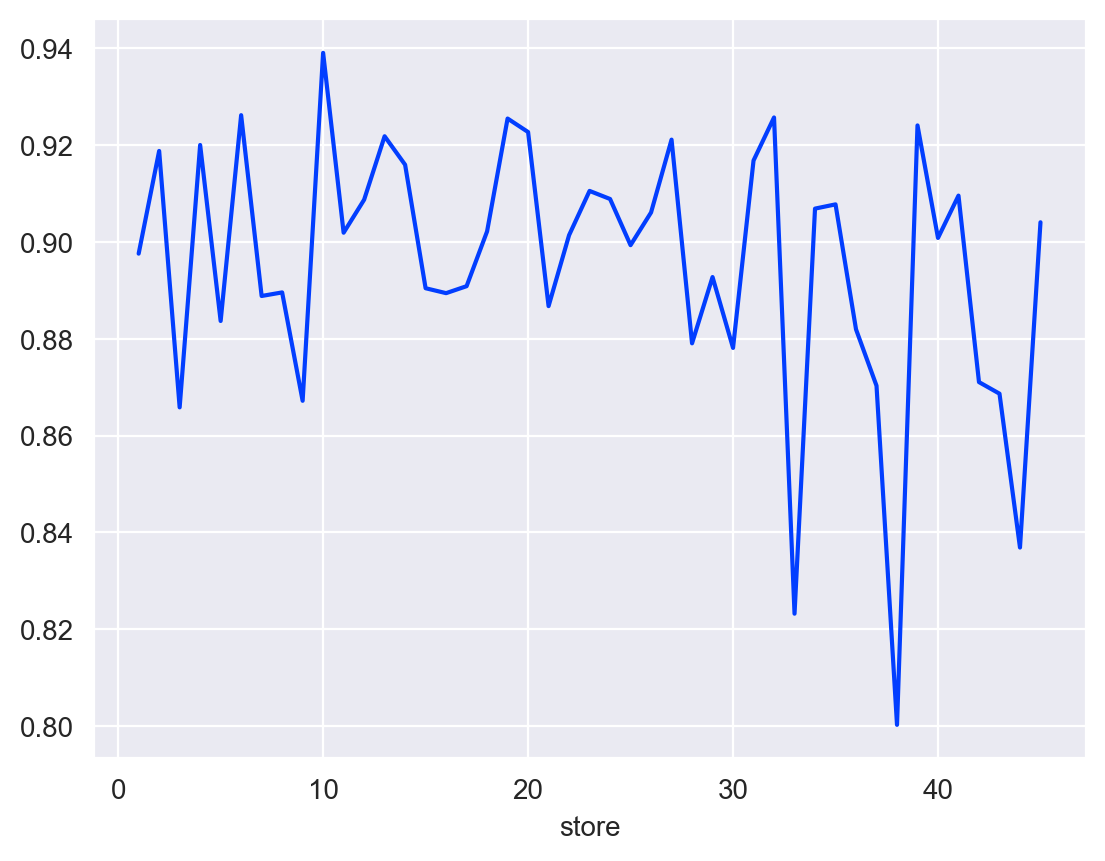

In [11]:
pred_res.groupby('store').ape.median().plot()

<Axes: >

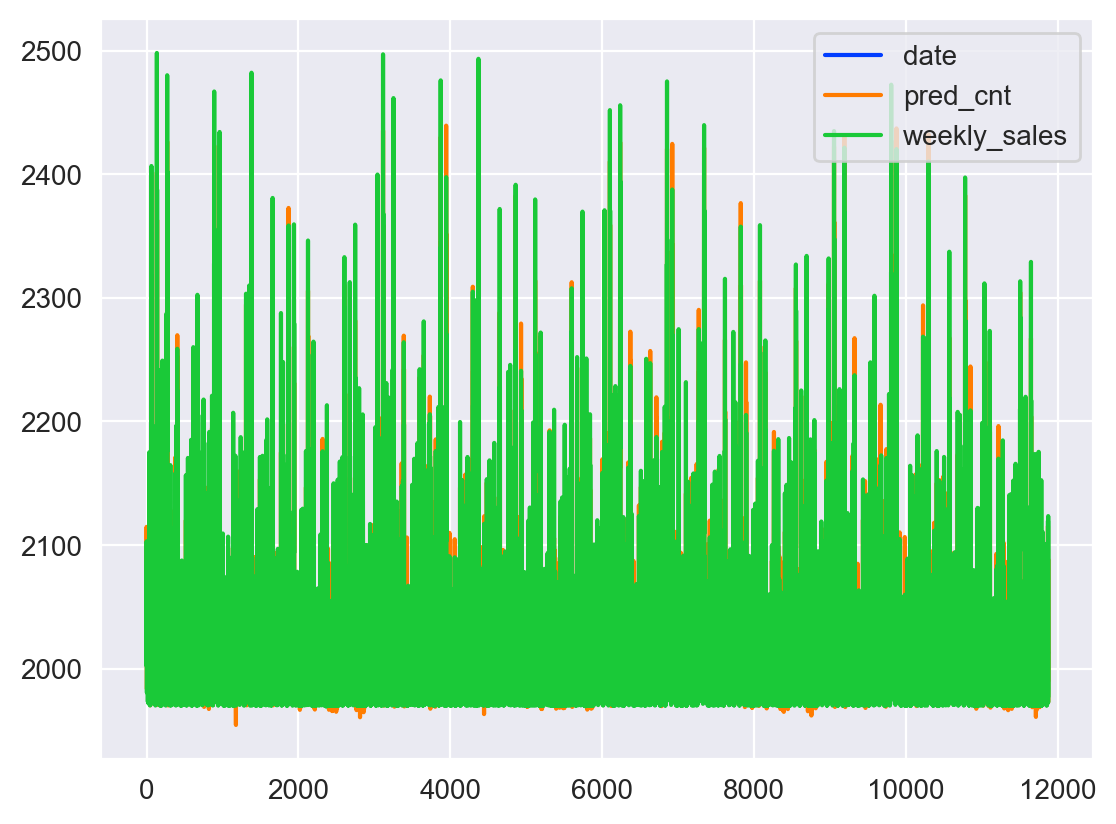

In [49]:
pred_res[['pred_cnt', 'weekly_sales']].reset_index().plot()

In [ ]:
    def fit_predict(self, df):
        
        # index를 date로 지정
        if 'date' in df.columns:
            df = df.set_index("date")             

        # 컬럼제거: leakage 방지
        drop_cols = ['weekly_sales', 'date_month', 'salse_cnt_cum']        
        test_idx = df[df.index >= self.test_start_date].index.drop_duplicates() # test 첫시작일
        
        # 최신값까지 누적하여 하나의 날짜에 대해 예측하고 append
        pred_res = pd.DataFrame()
        for date in test_idx:            
            print("train and predict of", date)            
            train = df[df.index < str(date)]
            pred = df[df.index == str(date)]

            train['type'] = self.label_encoder.fit_transform(train['type'])
            train['store_enc'] = self.target_encoder.fit_transform(train['store'], train['weekly_sales'])
            X_train = train.drop(drop_cols, axis=1)
            y_train = train[['weekly_sales']]

            # 성능 체크 용도
            pred['type'] = self.label_encoder.transform(pred['type'])
            pred['store_enc'] = self.target_encoder.transform(pred['store'], pred['weekly_sales'])
            X_pred = pred.drop(drop_cols, axis=1)
            y_pred = pred[['weekly_sales', 'store', 'dept']] 

            model = self.base_model                                                        
            model.fit(X_train, y_train)
            y_pred['pred_cnt'] = model.predict(X_pred).astype(int)
            pred_res = pred_res.append(y_pred)          
        
        # MdAPE
        pred_res['ape'] = 1-(abs(pred_res['weekly_sales']-pred_res['pred_cnt'])/pred_res['weekly_sales'])
        print(pred_res.ape.median())
        return df, pred_res
    